In [11]:
import os, json
from pathlib import Path
from google.colab import userdata

kaggle_dir = Path.home() / ".kaggle"
kaggle_json = kaggle_dir / "kaggle.json"
kaggle_dir.mkdir(parents=True, exist_ok=True)

u = userdata.get("KAGGLE_USERNAME")
k = userdata.get("KAGGLE_KEY")

print("Username loaded:", bool(u))
print("Key loaded:", bool(k))

with open(kaggle_json, "w") as f:
    json.dump({"username": u, "key": k}, f)

os.chmod(kaggle_json, 0o600)

print("Wrote:", kaggle_json, "size:", kaggle_json.stat().st_size)


Username loaded: True
Key loaded: True
Wrote: /root/.kaggle/kaggle.json size: 71


In [14]:
!ls -la ~/.kaggle
!cat ~/.kaggle/kaggle.json
!kaggle datasets list -s casia | head


total 16
drwxr-xr-x 2 root root 4096 Feb  2 06:15 .
drwx------ 1 root root 4096 Feb  2 06:14 ..
-rw------- 1 root root   71 Feb  2 06:28 kaggle.json
{"username": "tanvi12bisht", "key": "33ddb4cfeb070cf5bb082bda50880f03"}ref                                                          title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
sophatvathana/casia-dataset                                  casia dataset                                    5600476572  2018-10-04 04:10:13.540000          15782        152  0.3125           
sondosaabed/casia-iris-thousand                              CASIA-Iris-Thousand                               514629968  2024-06-14 17:35:40.447000           2852         18  1.0              
deba

In [15]:
# cell - 1
from pathlib import Path
import subprocess, shutil, zipfile

DATASET = "divg07/casia-20-image-tampering-detection-dataset"

ROOT = "/content/drive/MyDrive/Binary_classification_image_tampering"
CASIA_DIR = Path(ROOT) / "data" / "casia"
CASIA_DIR.mkdir(parents=True, exist_ok=True)

# Mount Drive
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
except Exception:
    pass

dst_au = CASIA_DIR / "Au"
dst_tp = CASIA_DIR / "Tp"

# If already normalized, skip everything
if dst_au.exists() and dst_tp.exists():
    print("CASIA already prepared:")
    print(" ", dst_au)
    print(" ", dst_tp)

else:
    # Install kaggle once
    if subprocess.run(["bash", "-lc", "command -v kaggle"], capture_output=True).returncode != 0:
        subprocess.run(["pip", "install", "-q", "kaggle"], check=True)

    # Download only if no zip exists
    zips = list(CASIA_DIR.glob("*.zip"))
    if not zips:
        print("Downloading CASIA from Kaggle…")
        subprocess.run(
            ["kaggle", "datasets", "download", "-d", DATASET, "-p", str(CASIA_DIR), "-o"],
            check=True
        )
        zips = list(CASIA_DIR.glob("*.zip"))

    zip_path = max(zips, key=lambda p: p.stat().st_mtime)

    # Unzip once
    marker = CASIA_DIR / ".unzipped"
    if not marker.exists():
        print("Unzipping:", zip_path.name)
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(CASIA_DIR)
        marker.touch()

    # Find Au/Tp somewhere inside extracted folders
    def find_class_dir(root: Path, name: str) -> Path:
        for p in root.rglob(name):
            if p.is_dir() and p.name == name:
                return p
        return None

    src_au = find_class_dir(CASIA_DIR, "Au")
    src_tp = find_class_dir(CASIA_DIR, "Tp")
    if src_au is None or src_tp is None:
        raise RuntimeError("Couldn't find 'Au' and 'Tp' folders after extraction.")

    # Normalize to CASIA_DIR/Au and CASIA_DIR/Tp
    if dst_au.exists(): shutil.rmtree(dst_au)
    if dst_tp.exists(): shutil.rmtree(dst_tp)

    shutil.copytree(src_au, dst_au)
    shutil.copytree(src_tp, dst_tp)

    print("Normalized class folders:")
    print(" ", dst_au)
    print(" ", dst_tp)


Unzipping: casia-20-image-tampering-detection-dataset.zip
Normalized class folders:
  /content/drive/MyDrive/Binary_classification_image_tampering/data/casia/Au
  /content/drive/MyDrive/Binary_classification_image_tampering/data/casia/Tp


In [16]:
# cell - 2 - counting number of images for each class
from pathlib import Path

ROOT = "/content/drive/MyDrive/Binary_classification_image_tampering"
CASIA_DIR = Path(ROOT) / "data" / "casia"
dst_au = CASIA_DIR / "Au"
dst_tp = CASIA_DIR / "Tp"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def count_images(dir_path: Path) -> int:
    return sum(1 for p in dir_path.rglob("*") if p.suffix.lower() in IMG_EXTS)

au_cnt = count_images(dst_au)
tp_cnt = count_images(dst_tp)

print(f"Au images: {au_cnt}")
print(f"Tp images: {tp_cnt}")
print(f"Total    : {au_cnt + tp_cnt}")



Au images: 7491
Tp images: 5123
Total    : 12614


In [17]:
# cell - 3
import numpy as np
import pandas as pd
from pathlib import Path

ROOT = "/content/drive/MyDrive/Binary_classification_image_tampering"
CASIA_DIR = Path(ROOT) / "data" / "casia"
SPLIT_DIR = Path(ROOT) / "splits"
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
CLASS_MAP = {"Au": 0, "Tp": 1}

def index_casia(casia_dir: Path) -> pd.DataFrame:
    rows = []
    for cls_name, label in CLASS_MAP.items():
        for f in (casia_dir / cls_name).rglob("*"):
            if f.suffix.lower() in IMG_EXTS:
                rows.append((str(f), label))
    return pd.DataFrame(rows, columns=["path", "label"])

def stratified_split(df: pd.DataFrame, val_ratio: float = 0.3, seed: int = 42):
    rng = np.random.default_rng(seed)
    tr_idx, va_idx = [], []

    for _, grp in df.groupby("label"):
        idx = grp.index.to_numpy()
        rng.shuffle(idx)
        k = int(len(idx) * val_ratio)
        va_idx.extend(idx[:k])
        tr_idx.extend(idx[k:])

    df_tr = df.loc[tr_idx].sample(frac=1, random_state=seed).reset_index(drop=True)
    df_va = df.loc[va_idx].sample(frac=1, random_state=seed).reset_index(drop=True)
    return df_tr, df_va

# build index + split
df_all = index_casia(CASIA_DIR)
df_tr, df_va = stratified_split(df_all, val_ratio=0.3, seed=42)

# save
paths = {
    "all": SPLIT_DIR / "casia_all.csv",
    "train": SPLIT_DIR / "casia_train.csv",
    "val": SPLIT_DIR / "casia_val.csv",
}
df_all.to_csv(paths["all"], index=False)
df_tr.to_csv(paths["train"], index=False)
df_va.to_csv(paths["val"], index=False)

# quick report
inv = {v: k for k, v in CLASS_MAP.items()}
print("Total indexed:", len(df_all))
print(df_all["label"].value_counts().rename(inv))

print(f"\n[Split] Train={len(df_tr)} | Val={len(df_va)}")
print("Train balance:\n", df_tr["label"].value_counts().rename(inv))
print("Val balance:\n", df_va["label"].value_counts().rename(inv))

print("\nSaved:")
for k, p in paths.items():
    print(f"  {k}: {p}")


Total indexed: 12614
label
Au    7491
Tp    5123
Name: count, dtype: int64

[Split] Train=8831 | Val=3783
Train balance:
 label
Au    5244
Tp    3587
Name: count, dtype: int64
Val balance:
 label
Au    2247
Tp    1536
Name: count, dtype: int64

Saved:
  all: /content/drive/MyDrive/Binary_classification_image_tampering/splits/casia_all.csv
  train: /content/drive/MyDrive/Binary_classification_image_tampering/splits/casia_train.csv
  val: /content/drive/MyDrive/Binary_classification_image_tampering/splits/casia_val.csv


In [18]:
# cell - 4
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

IMG_SIZE = 256
BATCH_SIZE = 32
NUM_WORKERS = 2

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

ROOT = "/content/drive/MyDrive/Binary_classification_image_tampering"
TR_CSV = f"{ROOT}/splits/casia_train.csv"
VA_CSV = f"{ROOT}/splits/casia_val.csv"

def build_tf(img_size: int, train: bool):
    if train:
        return transforms.Compose([
            transforms.Resize(int(img_size * 1.15)),
            transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])
    return transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

class TamperDataset(Dataset):
    def __init__(self, csv_path: str, tf):
        self.df = pd.read_csv(csv_path)
        self.tf = tf

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        x = Image.open(row["path"]).convert("RGB")
        x = self.tf(x)
        y = int(row["label"])
        return x, y

def make_loader(csv_path: str, img_size: int, train: bool):
    ds = TamperDataset(csv_path, build_tf(img_size, train))
    return DataLoader(
        ds,
        batch_size=BATCH_SIZE,
        shuffle=train,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

dl_tr = make_loader(TR_CSV, IMG_SIZE, train=True)
dl_va = make_loader(VA_CSV, IMG_SIZE, train=False)

xb, yb = next(iter(dl_tr))
print("Batch:", xb.shape, yb.shape)


Batch: torch.Size([32, 3, 256, 256]) torch.Size([32])


In [19]:
# cell - 5
# === CBAM + ResNet18-CBAM builder ===
import torch, torch.nn as nn
from torchvision import models
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CBAM modules
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        mid = max(1, in_planes // ratio)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, mid, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg = self.fc(self.avg_pool(x))
        mx = self.fc(self.max_pool(x))
        return self.sigmoid(avg + mx)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        p = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=p, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x2 = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x2))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)
    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

def insert_cbam_into_resnet18(m: models.ResNet) -> models.ResNet:
    def wrap_layer(layer):
        for i, block in enumerate(layer):
            out_ch = block.conv2.out_channels  # BasicBlock's last conv
            layer[i] = nn.Sequential(block, CBAM(out_ch))
    for layer in [m.layer1, m.layer2, m.layer3, m.layer4]:
        wrap_layer(layer)
    return m

def make_resnet18_cbam(num_classes=2):
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    m = insert_cbam_into_resnet18(m)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def count_params(model):
    tot = sum(p.numel() for p in model.parameters())
    trn = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return tot, trn

# quick test
xb, _ = next(iter(dl_tr))
xb = xb[:2].to(DEVICE)

model_cbam = make_resnet18_cbam().to(DEVICE)
with torch.no_grad():
    logits = model_cbam(xb)

print("logits:", logits.shape)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


logits: torch.Size([2, 2])


In [21]:
# cell - 6 (train baselines)

import os, math, warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT = "/content/drive/MyDrive/Binary_classification_image_tampering"
OUT = os.path.join(ROOT, "outputs")
os.makedirs(OUT, exist_ok=True)

def build_resnet18():
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    m.fc = nn.Linear(m.fc.in_features, 2)
    return m

def build_mobilenet_v3_small():
    m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
    m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, 2)
    return m

def build_efficientnet_b0():
    m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, 2)
    return m

BASELINES = {
    "resnet18": build_resnet18,
    "mobilenet_v3_small": build_mobilenet_v3_small,
    "efficientnet_b0": build_efficientnet_b0,
}

def metrics_from_probs(y_true, prob_pos):
    y_pred = (prob_pos >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, prob_pos)
    except Exception:
        auc = float("nan")
    return acc, f1, auc

@torch.no_grad()
def eval_metrics(model, loader):
    model.eval().to(DEVICE)
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        prob_pos = torch.softmax(model(xb), dim=1)[:, 1]
        ys.append(yb.numpy())
        ps.append(prob_pos.detach().cpu().numpy())
    y = np.concatenate(ys)
    p = np.concatenate(ps)
    return metrics_from_probs(y, p)

def train_one(model, name, epochs=12, lr=3e-4, wd=1e-4, label_smooth=0.05, early_stop=4):
    out_dir = os.path.join(OUT, name)
    os.makedirs(out_dir, exist_ok=True)
    best_path = os.path.join(out_dir, f"{name}_best.pt")
    hist_path = os.path.join(out_dir, f"{name}_history.csv")

    criterion = nn.CrossEntropyLoss(label_smoothing=label_smooth)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=2)
    scaler = torch.amp.GradScaler("cuda", enabled=torch.cuda.is_available())

    best_auc, patience = -1.0, 0
    history = []

    for ep in range(1, epochs + 1):
        model.train().to(DEVICE)
        run_loss, seen = 0.0, 0

        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            with torch.amp.autocast("cuda", enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)

            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            run_loss += loss.item() * xb.size(0)
            seen += xb.size(0)

        val_acc, val_f1, val_auc = eval_metrics(model, dl_va)
        sched.step(val_auc if not math.isnan(val_auc) else val_f1)

        improved = val_auc > best_auc
        if improved:
            best_auc, patience = val_auc, 0
            torch.save(model.state_dict(), best_path)
        else:
            patience += 1

        history.append({
            "epoch": ep,
            "train_loss": run_loss / max(1, seen),
            "val_acc": val_acc,
            "val_f1": val_f1,
            "val_auc": val_auc,
            "lr": opt.param_groups[0]["lr"],
        })

        if patience >= early_stop:
            break

    pd.DataFrame(history).to_csv(hist_path, index=False)

    model.load_state_dict(torch.load(best_path, map_location=DEVICE))
    val_acc, val_f1, val_auc = eval_metrics(model, dl_va)

    print(f"{name}: Acc={val_acc:.3f} F1={val_f1:.3f} AUC={val_auc:.3f} | ckpt={best_path}")
    return {
        "model": name,
        "Val_Acc": val_acc,
        "Val_F1": val_f1,
        "Val_AUC": val_auc,
        "ckpt": best_path,
        "history": hist_path,
    }

summary = []
for name, builder in BASELINES.items():
    summary.append(train_one(builder(), name))

df_sum = pd.DataFrame(summary)
sum_path = os.path.join(OUT, "baseline_training_summary.csv")
df_sum.to_csv(sum_path, index=False)

print("Saved:", sum_path)


resnet18: Acc=0.777 F1=0.713 AUC=0.880 | ckpt=/content/drive/MyDrive/Binary_classification_image_tampering/outputs/resnet18/resnet18_best.pt
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 197MB/s]


mobilenet_v3_small: Acc=0.717 F1=0.608 AUC=0.822 | ckpt=/content/drive/MyDrive/Binary_classification_image_tampering/outputs/mobilenet_v3_small/mobilenet_v3_small_best.pt
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 195MB/s]


efficientnet_b0: Acc=0.852 F1=0.824 AUC=0.935 | ckpt=/content/drive/MyDrive/Binary_classification_image_tampering/outputs/efficientnet_b0/efficientnet_b0_best.pt
Saved: /content/drive/MyDrive/Binary_classification_image_tampering/outputs/baseline_training_summary.csv


In [22]:
import os, glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

ROOT = "/content/drive/MyDrive/Binary_classification_image_tampering"
OUT_DIR = os.path.join(ROOT, "outputs")
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- model builders ---
def build_resnet18():
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    m.fc = nn.Linear(m.fc.in_features, 2)
    return m

def build_mobilenet_v3_small():
    m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
    m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, 2)
    return m

def build_efficientnet_b0():
    m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, 2)
    return m

BASELINES = {
    "resnet18": build_resnet18,
    "mobilenet_v3_small": build_mobilenet_v3_small,
    "efficientnet_b0": build_efficientnet_b0,
}

# --- checkpoint helpers (deterministic first, small fallback) ---
def expected_ckpt(name: str) -> str:
    return os.path.join(OUT_DIR, name, f"{name}_best.pt")

def find_ckpt_fallback(name: str) -> str | None:
    hits = glob.glob(os.path.join(OUT_DIR, "**", f"*{name}*best*.pt"), recursive=True)
    if not hits:
        hits = glob.glob(os.path.join(OUT_DIR, "**", f"*{name}*.pt"), recursive=True)
    if not hits:
        return None
    hits.sort(key=os.path.getmtime, reverse=True)
    return hits[0]

def load_ckpt_if_available(model: nn.Module, name: str) -> str | None:
    ckpt = expected_ckpt(name)
    if not os.path.isfile(ckpt):
        ckpt = find_ckpt_fallback(name)
    if not ckpt:
        return None

    sd = torch.load(ckpt, map_location=DEVICE)
    model.load_state_dict(sd, strict=False)
    return ckpt

# --- eval + metrics (binary) ---
@torch.no_grad()
def eval_probs(model: nn.Module, loader):
    model.eval().to(DEVICE)
    probs_list, y_list = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)  # [N,2]
        probs_list.append(probs.cpu().numpy())
        y_list.append(yb.numpy())
    return np.vstack(probs_list), np.concatenate(y_list)

def compute_metrics(y_true: np.ndarray, probs: np.ndarray):
    pred = probs.argmax(1)
    acc = accuracy_score(y_true, pred)
    f1 = f1_score(y_true, pred)
    try:
        auc = roc_auc_score(y_true, probs[:, 1])
    except Exception:
        auc = float("nan")
    return acc, f1, auc

# --- run ---
rows = []
for name, builder in BASELINES.items():
    model = builder()
    ckpt = load_ckpt_if_available(model, name)
    probs, y_true = eval_probs(model, dl_va)
    acc, f1, auc = compute_metrics(y_true, probs)

    rows.append({
        "model": name,
        "accuracy": round(acc, 4),
        "f1": round(f1, 4),
        "auc_roc": round(auc, 4) if not np.isnan(auc) else np.nan,
        "checkpoint_used": ckpt if ckpt else "ImageNet weights",
    })

df_baseline = pd.DataFrame(rows).sort_values("accuracy", ascending=False).reset_index(drop=True)

csv_path = os.path.join(OUT_DIR, "baseline_performance.csv")
df_baseline[["model", "accuracy", "f1", "auc_roc"]].to_csv(csv_path, index=False)

print(df_baseline[["model", "accuracy", "f1", "auc_roc", "checkpoint_used"]])
print("Saved:", csv_path)


                model  accuracy      f1  auc_roc  \
0     efficientnet_b0    0.8522  0.8240   0.9350   
1            resnet18    0.7772  0.7134   0.8795   
2  mobilenet_v3_small    0.7169  0.6081   0.8224   

                                     checkpoint_used  
0  /content/drive/MyDrive/Binary_classification_i...  
1  /content/drive/MyDrive/Binary_classification_i...  
2  /content/drive/MyDrive/Binary_classification_i...  
Saved: /content/drive/MyDrive/Binary_classification_image_tampering/outputs/baseline_performance.csv


Ep 01 | loss 0.5889 | AUC 0.801 | *
Ep 02 | loss 0.5341 | AUC 0.825 | *
Ep 03 | loss 0.5148 | AUC 0.829 | *
Ep 04 | loss 0.4921 | AUC 0.782 | 
Ep 05 | loss 0.4781 | AUC 0.827 | 
Ep 06 | loss 0.4677 | AUC 0.860 | *
Ep 07 | loss 0.4573 | AUC 0.883 | *
Ep 08 | loss 0.4432 | AUC 0.854 | 
Ep 09 | loss 0.4311 | AUC 0.898 | *
Ep 10 | loss 0.4171 | AUC 0.881 | 
Ep 11 | loss 0.4068 | AUC 0.864 | 
Ep 12 | loss 0.4023 | AUC 0.896 | 
Ep 13 | loss 0.3714 | AUC 0.911 | *
Ep 14 | loss 0.3687 | AUC 0.898 | 
Ep 15 | loss 0.3601 | AUC 0.909 | 


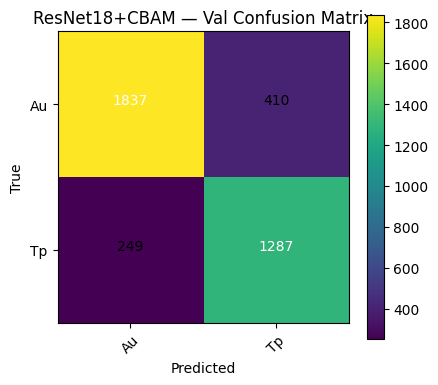

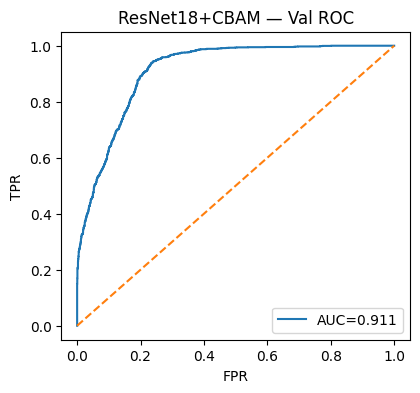

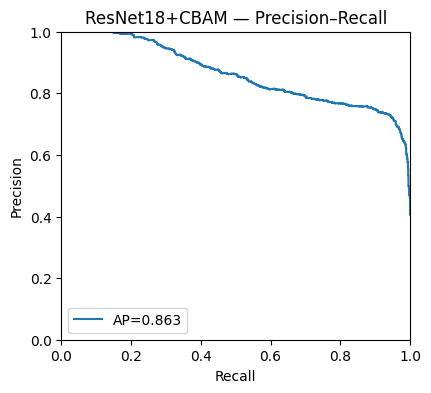

Saved artifacts to: /content/drive/MyDrive/Binary_classification_image_tampering/outputs/resnet18_cbam


In [23]:
# cell - 7 (ResNet18 + CBAM training)

import os, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve,
    precision_recall_curve, average_precision_score
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()
ROOT = "/content/drive/MyDrive/Binary_classification_image_tampering"
OUT = os.path.join(ROOT, "outputs", "resnet18_cbam")
os.makedirs(OUT, exist_ok=True)

# ------------------ plots ------------------
def plot_confusion(cm, classes=("Au", "Tp"), title="Confusion Matrix", save_path=None):
    plt.figure(figsize=(4.5, 4.0))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]:d}",
                     ha="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=160)
    plt.show()

def plot_roc(y_true, y_prob, title="ROC", save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(4.5, 4.0))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(title)
    plt.legend(loc="lower right")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=160)
    plt.show()

def plot_pr(y_true, y_prob, title="Precision–Recall", save_path=None):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    plt.figure(figsize=(4.5, 4.0))
    plt.plot(recall, precision, label=f"AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc="lower left")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=160)
    plt.show()

# ------------------ eval ------------------
@torch.no_grad()
def evaluate(model, loader, threshold=0.5):
    model.eval().to(DEVICE)
    ys, ps = [], []

    for xb, yb in loader:
        xb = xb.to(DEVICE)
        p1 = torch.softmax(model(xb), dim=1)[:, 1]
        ys.append(yb.numpy())
        ps.append(p1.detach().cpu().numpy())

    y = np.concatenate(ys)
    p = np.concatenate(ps)

    y_pred = (p >= threshold).astype(int)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    try:
        auc = roc_auc_score(y, p)
    except Exception:
        auc = float("nan")

    cm = confusion_matrix(y, y_pred)
    return acc, f1, auc, cm, y, p

# ------------------ training ------------------
model = make_resnet18_cbam().to(DEVICE)

EPOCHS = 15
EARLY_STOP_PATIENCE = 4
LR = 3e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTH = 0.05

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=2)
scaler = torch.amp.GradScaler("cuda", enabled=USE_CUDA)

best_auc, patience = -1.0, 0
best_path = os.path.join(OUT, "resnet18_cbam_best.pt")
hist_path = os.path.join(OUT, "history.csv")
history = []

for ep in range(1, EPOCHS + 1):
    model.train()
    run_loss, seen = 0.0, 0

    for xb, yb in dl_tr:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        with torch.amp.autocast("cuda", enabled=USE_CUDA):
            logits = model(xb)
            loss = criterion(logits, yb)

        opt.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        run_loss += loss.item() * xb.size(0)
        seen += xb.size(0)

    val_acc, val_f1, val_auc, _, _, _ = evaluate(model, dl_va)
    sched.step(val_auc if not math.isnan(val_auc) else val_f1)

    improved = val_auc > best_auc
    if improved:
        best_auc, patience = val_auc, 0
        torch.save(model.state_dict(), best_path)
    else:
        patience += 1

    history.append({
        "epoch": ep,
        "train_loss": run_loss / max(1, seen),
        "val_acc": val_acc,
        "val_f1": val_f1,
        "val_auc": val_auc,
        "lr": opt.param_groups[0]["lr"],
    })
    print(f"Ep {ep:02d} | loss {history[-1]['train_loss']:.4f} | AUC {val_auc:.3f} | {'*' if improved else ''}")

    if patience >= EARLY_STOP_PATIENCE:
        break

pd.DataFrame(history).to_csv(hist_path, index=False)

# ------------------ final eval from best + plots ------------------
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
acc, f1, auc, cm, y_true, y_prob = evaluate(model, dl_va)

pd.DataFrame([{
    "model": "resnet18_cbam",
    "accuracy": acc,
    "f1": f1,
    "auc_roc": auc,
}]).to_csv(os.path.join(OUT, "val_summary.csv"), index=False)

plot_confusion(cm, title="ResNet18+CBAM — Val Confusion Matrix",
               save_path=os.path.join(OUT, "val_cm.png"))
plot_roc(y_true, y_prob, title="ResNet18+CBAM — Val ROC",
         save_path=os.path.join(OUT, "val_roc.png"))
plot_pr(y_true, y_prob, title="ResNet18+CBAM — Precision–Recall",
        save_path=os.path.join(OUT, "val_pr.png"))

print("Saved artifacts to:", OUT)


Ep 01 | loss 0.5168 | AUC 0.802 | *
Ep 02 | loss 0.3959 | AUC 0.815 | *
Ep 03 | loss 0.3462 | AUC 0.808 | 
Ep 04 | loss 0.3161 | AUC 0.834 | *
Ep 05 | loss 0.2968 | AUC 0.837 | *
Ep 06 | loss 0.2770 | AUC 0.825 | 
Ep 07 | loss 0.2625 | AUC 0.834 | 
Ep 08 | loss 0.2580 | AUC 0.835 | 
Ep 09 | loss 0.2348 | AUC 0.840 | *
Ep 10 | loss 0.2252 | AUC 0.835 | 
Ep 11 | loss 0.2208 | AUC 0.842 | *
Ep 12 | loss 0.2151 | AUC 0.838 | 


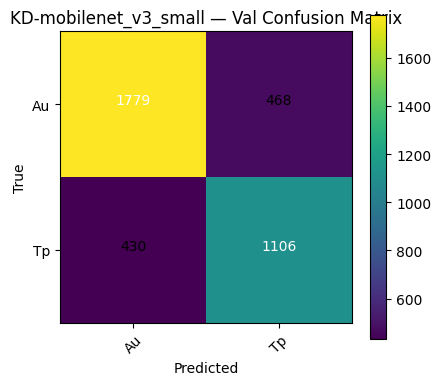

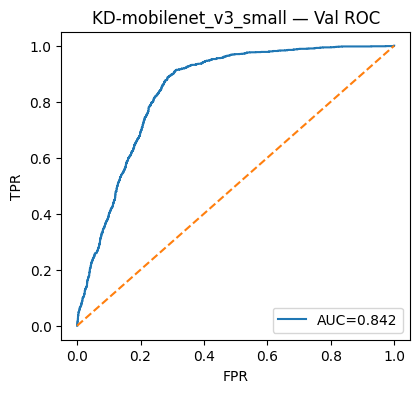

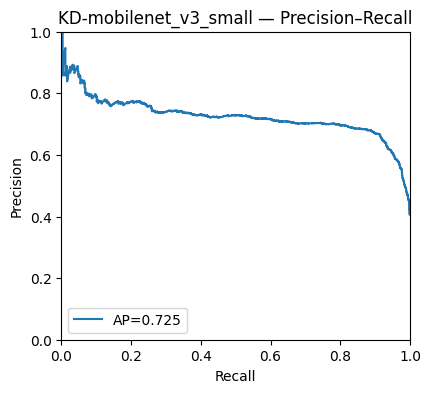

Saved KD artifacts to: /content/drive/MyDrive/Binary_classification_image_tampering/outputs/kd_mobilenet_v3_small
Updated: /content/drive/MyDrive/Binary_classification_image_tampering/outputs/modified_performance.csv


In [26]:
# cell - 8 (KD optimized)

import os, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve,
    precision_recall_curve, average_precision_score
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()

ROOT = "/content/drive/MyDrive/Binary_classification_image_tampering"
OUTDIR_CBAM = os.path.join(ROOT, "outputs", "resnet18_cbam")
TEACHER_CKPT = os.path.join(OUTDIR_CBAM, "resnet18_cbam_best.pt")

# assumes dl_tr, dl_va, make_resnet18_cbam exist
assert os.path.isfile(TEACHER_CKPT), "Teacher checkpoint missing. Train CBAM first."

# ---------------- config ----------------
STUDENT_NAME = "mobilenet_v3_small"
EPOCHS = 12
EARLY_STOP = 4
LR = 3e-4
WEIGHT_DECAY = 1e-4

KD_T = 4.0
KD_ALPHA = 0.7
LABEL_SMOOTH = 0.05

OUT = os.path.join(ROOT, "outputs", f"kd_{STUDENT_NAME}")
os.makedirs(OUT, exist_ok=True)
BEST_CKPT = os.path.join(OUT, f"kd_{STUDENT_NAME}_best.pt")
HIST_CSV  = os.path.join(OUT, "history.csv")

# ---------------- plots ----------------
def plot_confusion(cm, classes=("Au","Tp"), title="Confusion Matrix", save_path=None):
    plt.figure(figsize=(4.5,4.0))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    thresh = cm.max()/2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i,j]:d}", ha="center",
                     color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=160)
    plt.show()

def plot_roc(y_true, y_prob, title="ROC", save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(4.5,4.0))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(title)
    plt.legend(loc="lower right")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=160)
    plt.show()

def plot_pr(y_true, y_prob, title="Precision–Recall", save_path=None):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    plt.figure(figsize=(4.5,4.0))
    plt.plot(recall, precision, label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(title)
    plt.legend(loc="lower left")
    plt.xlim([0,1]); plt.ylim([0,1])
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=160)
    plt.show()

# ---------------- eval ----------------
@torch.no_grad()
def evaluate(model, loader, threshold=0.5):
    model.eval().to(DEVICE)
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        p1 = torch.softmax(model(xb), dim=1)[:, 1]
        ys.append(yb.numpy())
        ps.append(p1.detach().cpu().numpy())

    y = np.concatenate(ys)
    p = np.concatenate(ps)

    y_pred = (p >= threshold).astype(int)
    acc = accuracy_score(y, y_pred)
    f1  = f1_score(y, y_pred)
    try:
        auc = roc_auc_score(y, p)
    except Exception:
        auc = float("nan")

    cm = confusion_matrix(y, y_pred)
    return acc, f1, auc, cm, y, p

# ---------------- models ----------------
def build_student(name: str) -> nn.Module:
    builders = {
        "mobilenet_v3_small": lambda: models.mobilenet_v3_small(
            weights=models.MobileNet_V3_Small_Weights.DEFAULT
        ),
        "resnet18": lambda: models.resnet18(
            weights=models.ResNet18_Weights.DEFAULT
        ),
        "efficientnet_b0": lambda: models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.DEFAULT
        ),
    }
    if name not in builders:
        raise ValueError(f"Unknown student '{name}'")

    m = builders[name]()

    # replace final classifier for 2 classes
    if name == "resnet18":
        m.fc = nn.Linear(m.fc.in_features, 2)
    else:
        m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, 2)
    return m

teacher = make_resnet18_cbam().to(DEVICE)
teacher.load_state_dict(torch.load(TEACHER_CKPT, map_location=DEVICE))
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False

student = build_student(STUDENT_NAME).to(DEVICE)

# ---------------- KD loss ----------------
def kd_loss(student_logits, teacher_logits, y_true):
    ce = F.cross_entropy(student_logits, y_true, label_smoothing=LABEL_SMOOTH)

    T = KD_T
    log_p_s = F.log_softmax(student_logits / T, dim=1)
    p_t = F.softmax(teacher_logits / T, dim=1)
    kl = F.kl_div(log_p_s, p_t, reduction="batchmean") * (T * T)

    loss = KD_ALPHA * kl + (1.0 - KD_ALPHA) * ce
    return loss, ce.detach(), kl.detach()

# ---------------- train ----------------
opt = torch.optim.AdamW(student.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=2)
scaler = torch.amp.GradScaler("cuda", enabled=USE_CUDA)

best_auc, patience = -1.0, 0
history = []

for ep in range(1, EPOCHS + 1):
    student.train()
    run_loss, seen = 0.0, 0
    ce_vals, kl_vals = [], []

    for xb, yb in dl_tr:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        with torch.amp.autocast("cuda", enabled=USE_CUDA):
            with torch.no_grad():
                t_logits = teacher(xb)
            s_logits = student(xb)
            loss, ce, kl = kd_loss(s_logits, t_logits, yb)

        opt.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        run_loss += loss.item() * xb.size(0)
        seen += xb.size(0)
        ce_vals.append(ce.item())
        kl_vals.append(kl.item())

    val_acc, val_f1, val_auc, _, _, _ = evaluate(student, dl_va)
    sched.step(val_auc if not math.isnan(val_auc) else val_f1)

    improved = val_auc > best_auc
    if improved:
        best_auc, patience = val_auc, 0
        torch.save(student.state_dict(), BEST_CKPT)
    else:
        patience += 1

    history.append({
        "epoch": ep,
        "train_loss": run_loss / max(1, seen),
        "train_ce": float(np.mean(ce_vals)),
        "train_kl": float(np.mean(kl_vals)),
        "val_acc": val_acc,
        "val_f1": val_f1,
        "val_auc": val_auc,
        "lr": opt.param_groups[0]["lr"],
    })

    print(f"Ep {ep:02d} | loss {history[-1]['train_loss']:.4f} | AUC {val_auc:.3f} | {'*' if improved else ''}")

    if patience >= EARLY_STOP:
        break

pd.DataFrame(history).to_csv(HIST_CSV, index=False)

# ---------------- final eval + plots ----------------
student.load_state_dict(torch.load(BEST_CKPT, map_location=DEVICE))
acc, f1, auc, cm, y_true, y_prob = evaluate(student, dl_va)

pd.DataFrame([{
    "model": f"kd_{STUDENT_NAME}",
    "accuracy": acc,
    "f1": f1,
    "auc_roc": auc
}]).to_csv(os.path.join(OUT, "val_summary.csv"), index=False)

plot_confusion(cm, title=f"KD-{STUDENT_NAME} — Val Confusion Matrix",
               save_path=os.path.join(OUT, "val_cm.png"))
plot_roc(y_true, y_prob, title=f"KD-{STUDENT_NAME} — Val ROC",
         save_path=os.path.join(OUT, "val_roc.png"))
plot_pr(y_true, y_prob, title=f"KD-{STUDENT_NAME} — Precision–Recall",
        save_path=os.path.join(OUT, "val_pr.png"))

# ---------------- update modified_performance.csv ----------------
mod_perf_csv = os.path.join(ROOT, "outputs", "modified_performance.csv")

rows = []
cbam_sum = os.path.join(OUTDIR_CBAM, "val_summary.csv")
if os.path.isfile(cbam_sum):
    rows.append(pd.read_csv(cbam_sum).iloc[0].to_dict())

rows.append({"model": f"kd_{STUDENT_NAME}", "accuracy": acc, "f1": f1, "auc_roc": auc})

pd.DataFrame(rows)[["model", "accuracy", "f1", "auc_roc"]].to_csv(mod_perf_csv, index=False)

print("Saved KD artifacts to:", OUT)
print("Updated:", mod_perf_csv)


In [28]:
# cell - 9 (DRY + uses real KD checkpoint)

import os, time
import torch
import pandas as pd
from torch import nn
from torchvision import models

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ROOT = "/content/drive/MyDrive/Binary_classification_image_tampering"
OUTCSV = os.path.join(ROOT, "outputs", "efficiency_comparison.csv")
os.makedirs(os.path.dirname(OUTCSV), exist_ok=True)

KD_STUDENT = "mobilenet_v3_small"
IMG_SIZE = 256
BATCH_SIZE = 32

def _set_head(m, arch: str, num_classes: int = 2):
    if arch == "resnet18":
        m.fc = nn.Linear(m.fc.in_features, num_classes)
    else:
        m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, num_classes)
    return m

def build_model(arch: str, num_classes: int = 2):
    if arch == "resnet18":
        return _set_head(models.resnet18(weights=models.ResNet18_Weights.DEFAULT), arch, num_classes)
    if arch == "mobilenet_v3_small":
        return _set_head(models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT), arch, num_classes)
    if arch == "efficientnet_b0":
        return _set_head(models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT), arch, num_classes)
    if arch == "resnet18_cbam":
        return make_resnet18_cbam(num_classes=num_classes)
    raise ValueError(f"Unknown arch '{arch}'")

def count_params(model) -> int:
    return sum(p.numel() for p in model.parameters())

def checkpoint_size_mb_from_state_dict(model, tmp_dir="/content/tmp_ckpts", fname="tmp.pt"):
    os.makedirs(tmp_dir, exist_ok=True)
    path = os.path.join(tmp_dir, fname)
    torch.save(model.state_dict(), path)
    sz = os.path.getsize(path) / (1024 * 1024)
    os.remove(path)
    return sz

def timed_inference_ms_per_img(model, batch_size=BATCH_SIZE, img_size=IMG_SIZE, warmup=8, iters=40):
    model = model.to(DEVICE).eval()
    x = torch.randn(batch_size, 3, img_size, img_size, device=DEVICE)
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(x)
        if DEVICE.type == "cuda":
            torch.cuda.synchronize()
        t0 = time.time()
        for _ in range(iters):
            _ = model(x)
        if DEVICE.type == "cuda":
            torch.cuda.synchronize()
        t1 = time.time()
    return (t1 - t0) * 1000.0 / (batch_size * iters)

def kd_ckpt_path(student_name: str):
    return os.path.join(ROOT, "outputs", f"kd_{student_name}", f"kd_{student_name}_best.pt")

def try_load(model, ckpt_path: str):
    if os.path.isfile(ckpt_path):
        sd = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(sd, strict=False)
        return True
    return False

models_to_test = [
    ("resnet18", "resnet18", None),
    ("mobilenet_v3_small", "mobilenet_v3_small", None),
    ("efficientnet_b0", "efficientnet_b0", None),
    ("resnet18_cbam", "resnet18_cbam", None),
    (f"kd_{KD_STUDENT}", KD_STUDENT, kd_ckpt_path(KD_STUDENT)),
]

rows = []
for display_name, arch, ckpt in models_to_test:
    m = build_model(arch)
    weights_used = "ImageNet init"
    if ckpt and try_load(m, ckpt):
        weights_used = "trained ckpt"

    params_m = count_params(m) / 1e6
    size_mb = checkpoint_size_mb_from_state_dict(m, fname=f"{display_name}.pt")
    latency = timed_inference_ms_per_img(m)

    rows.append({
        "Model": display_name,
        "Weights": weights_used,
        "Params (M)": round(params_m, 3),
        "Checkpoint Size (MB)": round(size_mb, 2),
        "Latency (ms/img, bs=32)": round(latency, 3),
    })

df_eff = pd.DataFrame(rows).sort_values("Params (M)").reset_index(drop=True)
df_eff.to_csv(OUTCSV, index=False)

print("Saved:", OUTCSV)
display(df_eff)


Saved: /content/drive/MyDrive/Binary_classification_image_tampering/outputs/efficiency_comparison.csv


,Model,Weights,Params (M),Checkpoint Size (MB),"Latency (ms/img, bs=32)"
0,mobilenet_v3_small,ImageNet init,1.520,5.93,0.307
1,kd_mobilenet_v3_small,trained ckpt,1.520,5.93,0.285
2,efficientnet_b0,ImageNet init,4.010,15.58,1.433
3,resnet18,ImageNet init,11.178,42.71,0.998
4,resnet18_cbam,ImageNet init,11.265,43.06,1.286
